In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc




import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


In [2]:
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/train_data.csv
./input/test_data.csv
./input/sample_submission.csv


In [3]:
# Load the datasets

train_data = pd.read_csv('./input/train_data.csv')
test_data = pd.read_csv('./input/test_data.csv')
sample_submission = pd.read_csv('./input/test_data.csv')

In [4]:
train_data.columns = train_data.columns.str.strip().str.replace(' ', '_')
test_data.columns = test_data.columns.str.strip().str.replace(' ', '_')

In [5]:
numerical_columns = ['Limit_balance', 'Age', 'Pay_1', 'Pay_2', 'Pay_3', 'Pay_4', 'Pay_5', 'Pay_6', 
                     'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 
                     'Pay_amt1', 'Pay_amt2', 'Pay_amt3', 'Pay_amt4', 'Pay_amt5', 'Pay_amt6',
                     'Bureau_score', 'Tenure_years', 'Credit_utilisation_ratio', 
                     'Average_payment_delay', 'Total_payments', 'Total_bill_amount', 'Payment_consistency']

# Replace empty strings with np.nan and ensure numerical columns are converted to numeric types
for col in numerical_columns:
    train_data[col] = train_data[col].replace(' -   ', np.nan).astype(float)
    
for col in numerical_columns:
    test_data[col] = test_data[col].replace(' -   ', np.nan).astype(float)
    
# Ensure numerical columns are converted to numeric types and handle NaNs
for col in numerical_columns:
    if col in train_data.columns:
        train_data[col] = pd.to_numeric(train_data[col], errors='coerce').fillna(0)  # Fill NaNs with 0 or appropriate value
    if col in test_data.columns:
        test_data[col] = pd.to_numeric(test_data[col], errors='coerce').fillna(0)  # Fill NaNs with 0 or appropriate value

In [6]:
train_data.head()

,ID,TARGET,Limit_balance,Sex,Education,Marriage,Age,Pay_1,Pay_2,Pay_3,Pay_4,Pay_5,Pay_6,Bill_amt1,Bill_amt2,Bill_amt3,Bill_amt4,Bill_amt5,Bill_amt6,Pay_amt1,Pay_amt2,Pay_amt3,Pay_amt4,Pay_amt5,Pay_amt6,City,State,Credit_tier,Bureau_score,Date_account_opened,Tenure_years,Credit_utilisation_ratio,Average_payment_delay,Total_payments,Total_bill_amount,Payment_consistency,Age_group
0,1,1,120000.0,2,2,2,26.0,-1.0,2.0,0.0,0.0,0.0,2.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,Phoenix,TX,Basic,688.0,2017/07/22,6.0,0.14,0.50,5000.0,17077.0,753.0,Young
1,2,0,90000.0,2,2,2,34.0,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,Chicago,NY,Gold,482.0,2019/01/08,5.0,1.13,0.00,11018.0,101653.0,1570.0,Middle-aged
2,3,0,50000.0,1,2,1,57.0,-1.0,0.0,-1.0,0.0,0.0,0.0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,Phoenix,AZ,Gold,560.0,2017/01/03,7.0,2.19,-0.33,59049.0,109339.0,13786.0,Senior
3,4,0,50000.0,1,1,2,37.0,0.0,0.0,0.0,0.0,0.0,0.0,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,Phoenix,AZ,Platinum,376.0,2021/02/08,3.0,4.76,0.00,7772.0,238114.0,714.0,Middle-aged
4,5,0,500000.0,1,1,2,29.0,0.0,0.0,0.0,0.0,0.0,0.0,367965.0,412023.0,445007.0,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,Phoenix,NY,Platinum,497.0,2017/01/08,7.0,5.45,0.00,180759.0,2724595.0,16803.0,Young


In [7]:
train_data.describe()

,ID,TARGET,Limit_balance,Sex,Education,Marriage,Age,Pay_1,Pay_2,Pay_3,Pay_4,Pay_5,Pay_6,Bill_amt1,Bill_amt2,Bill_amt3,Bill_amt4,Bill_amt5,Bill_amt6,Pay_amt1,Pay_amt2,Pay_amt3,Pay_amt4,Pay_amt5,Pay_amt6,Bureau_score,Tenure_years,Credit_utilisation_ratio,Average_payment_delay,Total_payments,Total_bill_amount,Payment_consistency
count,33371.000000,33371.000000,33371.000000,33371.000000,33371.000000,33371.00000,33371.000000,33371.000000,33371.000000,33371.000000,33371.000000,33371.000000,33371.000000,33371.000000,33371.000000,3.337100e+04,33371.000000,33371.000000,33371.000000,3.337100e+04,3.337100e+04,33371.000000,33371.000000,33371.000000,33371.000000,33371.000000,33371.000000,33371.000000,33371.000000,3.337100e+04,3.337100e+04,33371.000000
mean,16686.000000,0.222828,167577.477450,1.604657,1.857301,1.54826,35.313536,-0.001558,-0.097540,-0.129993,-0.174942,-0.219112,-0.234665,51059.603039,48993.821192,4.688961e+04,43091.397501,40397.666956,39046.568697,5.616850e+03,5.833870e+03,5216.459800,4888.850529,4784.690809,5225.723832,575.054838,4.992508,2.242001,-0.180530,3.156644e+04,2.689563e+05,5799.724461
std,9633.522253,0.416150,130223.981275,0.488932,0.792353,0.52057,9.516603,1.037186,1.108356,1.105847,1.084650,1.047363,1.069524,73167.014011,70568.898677,6.891331e+04,63597.035137,60683.689706,59167.739114,1.741170e+04,2.351276e+04,18029.046196,16849.842764,15213.322727,17935.721816,158.562919,2.583970,2.130964,0.982692,6.476646e+04,3.764002e+05,15176.525985
min,1.000000,0.000000,7000.000000,1.000000,0.000000,0.00000,15.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,300.000000,1.000000,-1.400000,-2.250000,0.000000e+00,-3.362590e+05,0.000000
25%,8343.500000,0.000000,55000.000000,1.000000,1.000000,1.00000,28.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3441.500000,2946.000000,2.697500e+03,2350.000000,1772.000000,1329.000000,8.820000e+02,7.920000e+02,390.000000,264.000000,253.000000,94.000000,438.000000,3.000000,0.180000,-0.830000,6.626500e+03,2.778950e+04,628.000000
50%,16686.000000,0.000000,140000.000000,2.000000,2.000000,2.00000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22173.000000,21349.000000,2.024600e+04,19099.000000,18106.000000,17056.000000,2.130000e+03,2.034000e+03,1777.000000,1500.000000,1509.000000,1500.000000,575.000000,5.000000,1.710000,0.000000,1.434700e+04,1.264310e+05,1431.000000
75%,25028.500000,0.000000,240000.000000,2.000000,2.000000,2.00000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66982.000000,63645.000000,5.990500e+04,54333.500000,50543.500000,49458.500000,5.030000e+03,5.000000e+03,4500.000000,4001.000000,4081.000000,4010.000000,712.500000,7.000000,4.120000,0.000000,3.335400e+04,3.426170e+05,4114.500000
max,33371.000000,1.000000,1000000.000000,2.000000,6.000000,3.00000,87.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,1.064466e+06,1.684259e+06,897851.000000,736615.000000,426529.000000,528666.000000,850.000000,10.000000,32.190000,6.000000,4.228631e+06,5.263883e+06,650098.000000


In [8]:
train_data.describe(exclude='number')


,City,State,Credit_tier,Date_account_opened,Age_group
count,33371,33371,33371,33371,33371
unique,5,5,4,3286,3
top,Los Angeles,CA,Basic,2018/04/13,Middle-aged
freq,6766,6727,8445,25,19311


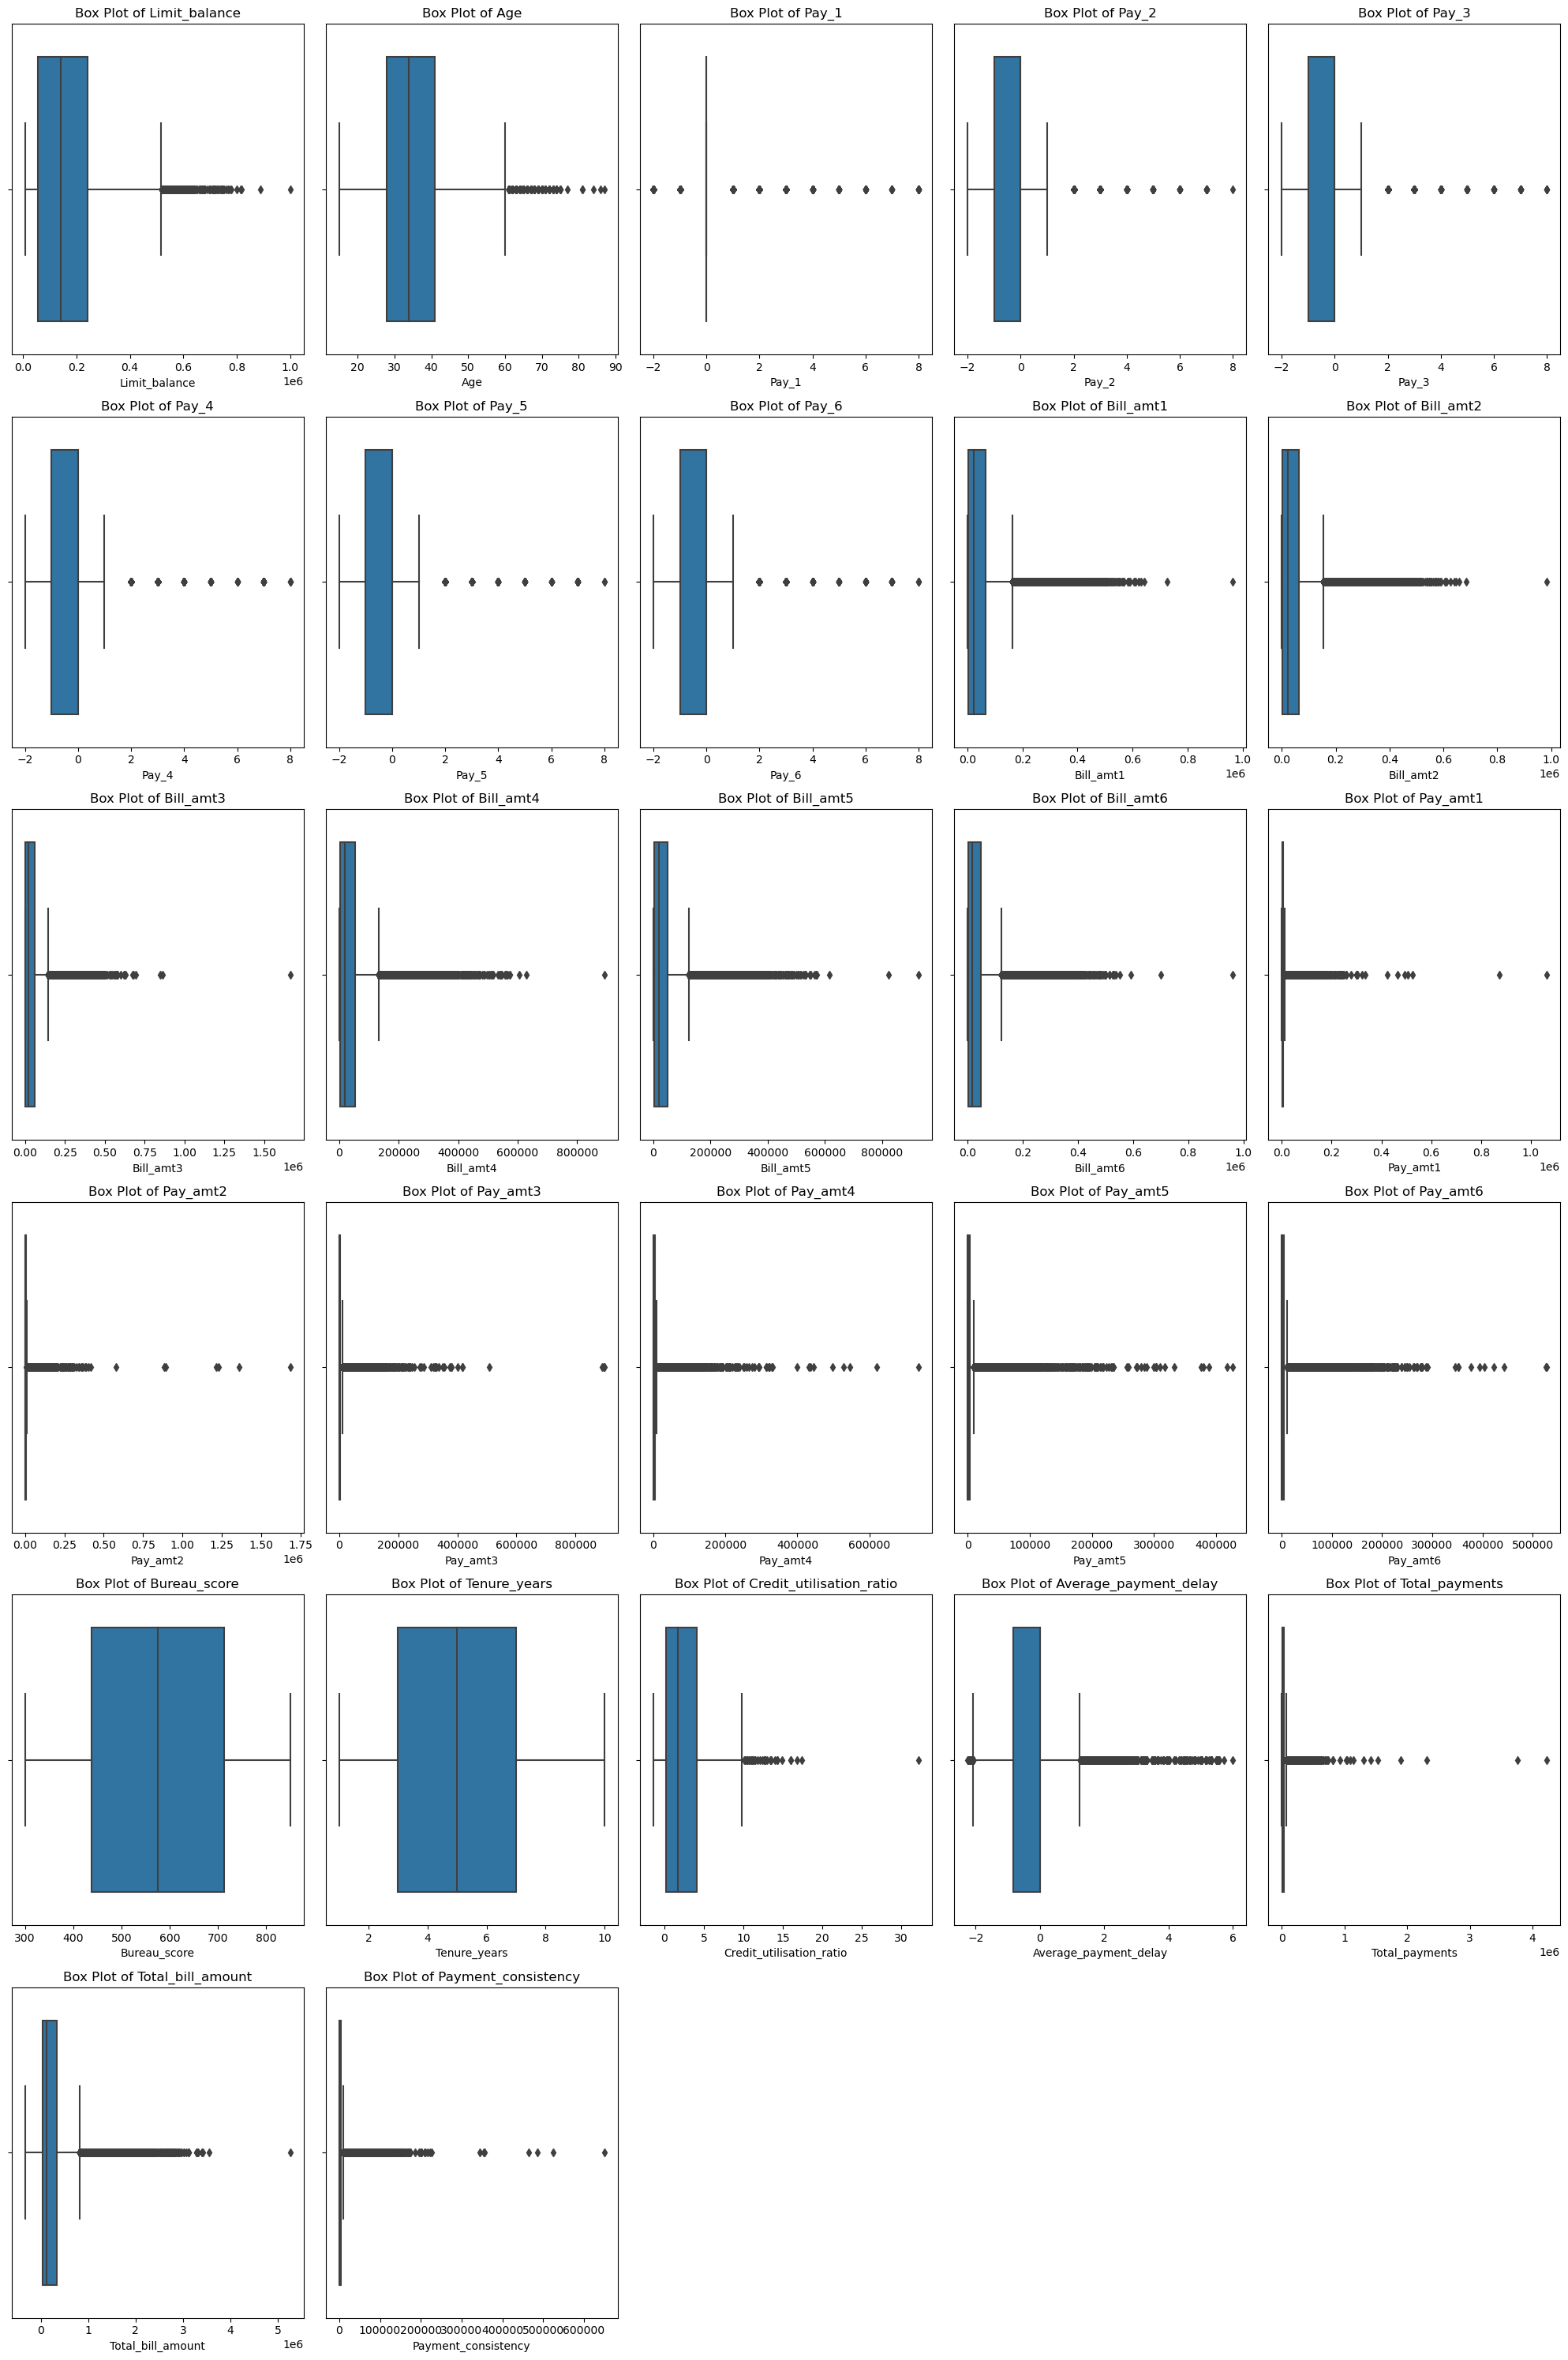

In [9]:
plots_per_row = 5
num_features = len(numerical_columns)
num_rows = (num_features + plots_per_row - 1) // plots_per_row  # Calculate number of rows needed

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, 5 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create box plots for each numerical feature
for i, feature in enumerate(numerical_columns):
    sns.boxplot(x=train_data[feature], ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature}')
    axes[i].set_xlabel(feature)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [10]:
train_data['TARGET'].value_counts()
# 1: default 0: No default

TARGET
0    25935
1     7436
Name: count, dtype: int64

<Axes: xlabel='TARGET', ylabel='count'>

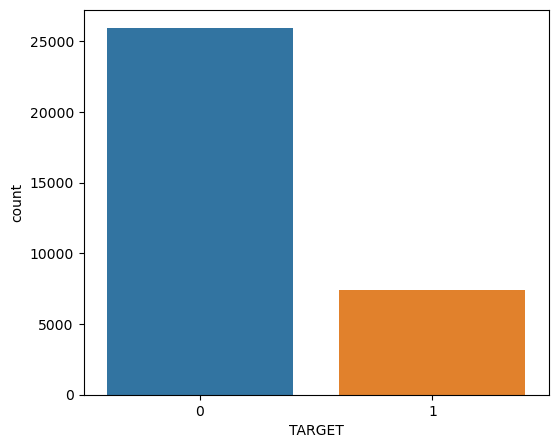

In [11]:
#value count plot for IsDefaulter
plt.figure(figsize=(6,5))
sns.countplot(x = 'TARGET', data = train_data)

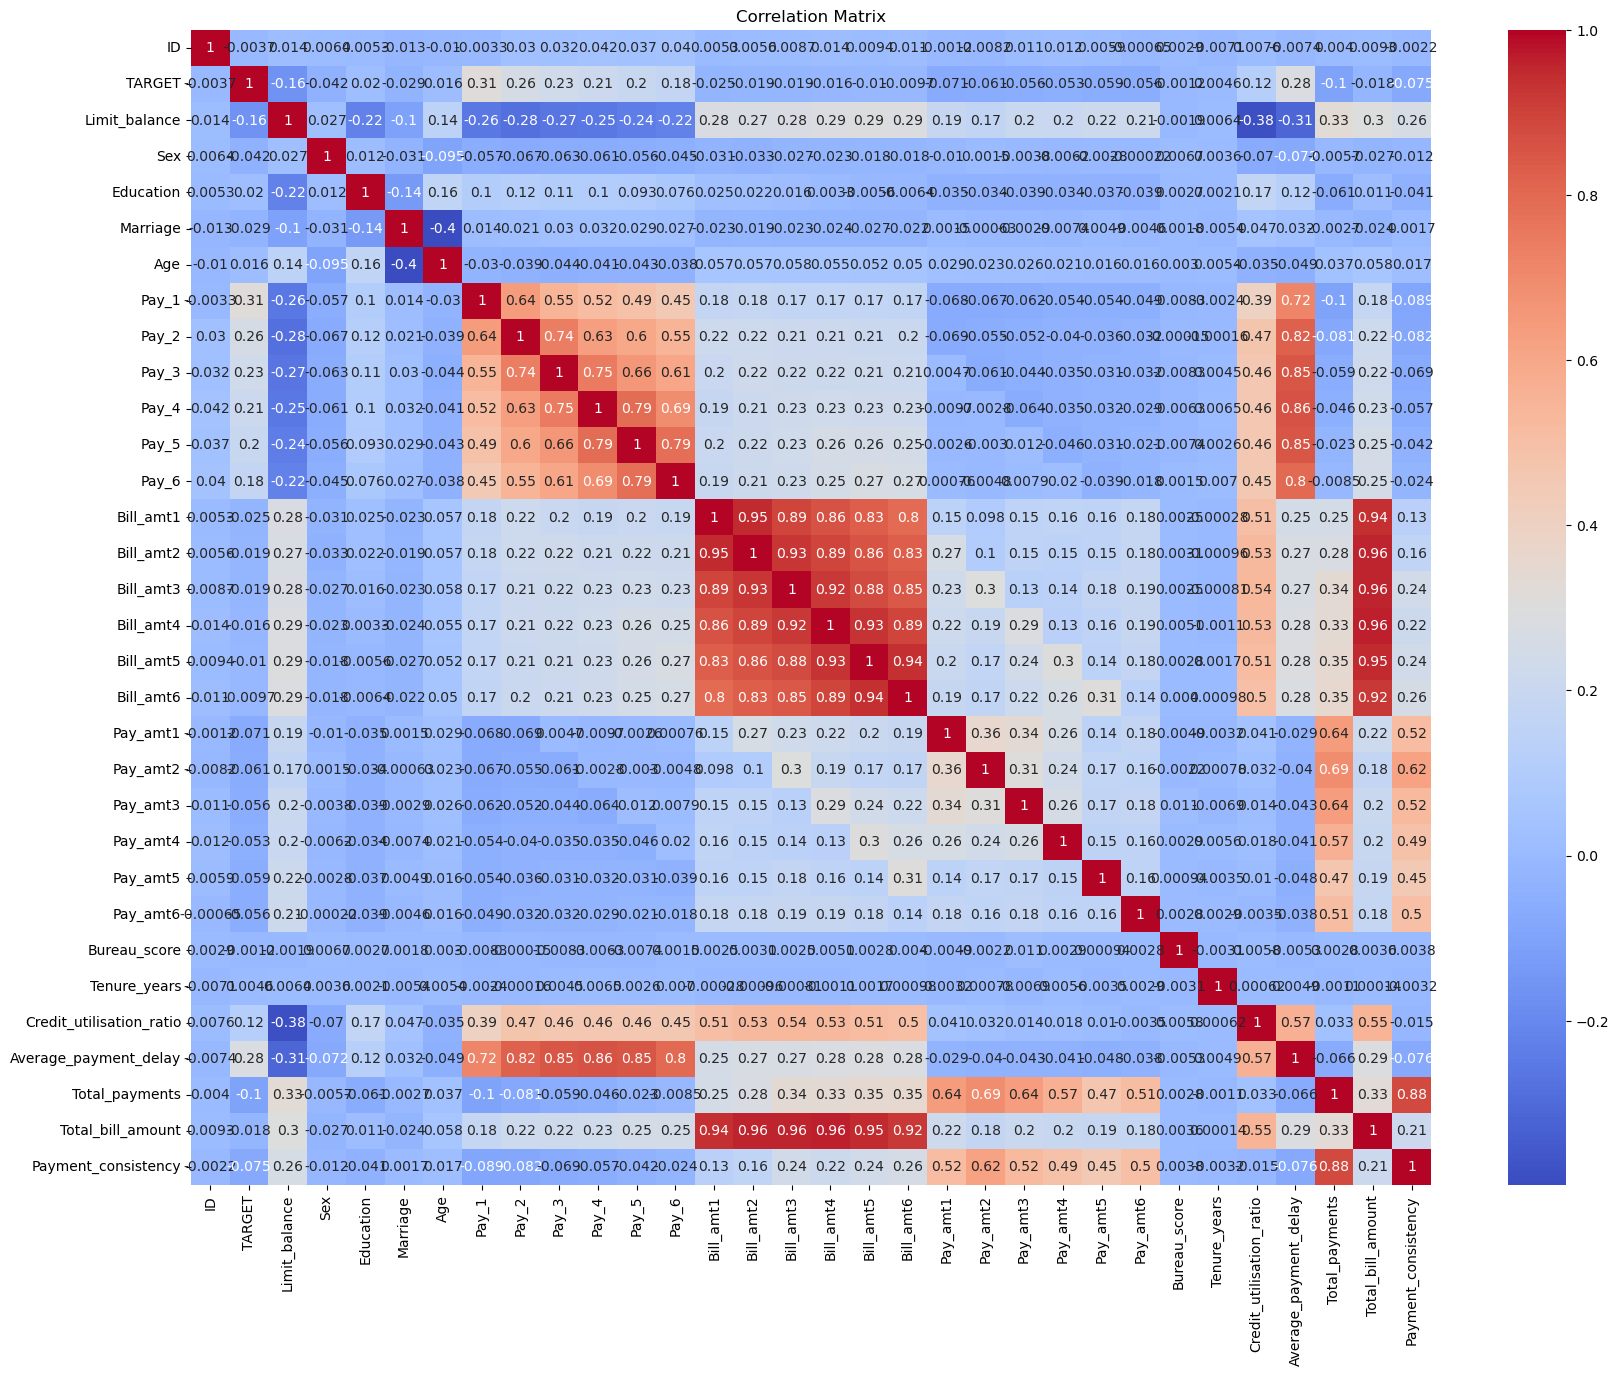

In [12]:
# Correlation matrix
plt.figure(figsize=(20, 15))
correlation_matrix = train_data.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [13]:
# Convert date to datetime: Just drop date time as its not rel and prevents some cal such as smote
# train_data['Date_account_opened'] = pd.to_datetime(train_data['Date_account_opened'])
train_data.drop(columns=['Date_account_opened'], inplace=True)

# Continuous cols
continuous_columns = ['Limit_balance', 'Age', 'Pay_1', 'Pay_2', 'Pay_3', 'Pay_4', 'Pay_5', 'Pay_6',
                       'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6',
                       'Pay_amt1', 'Pay_amt2', 'Pay_amt3', 'Pay_amt4', 'Pay_amt5', 'Pay_amt6', 'Bureau_score',
                       'Credit_utilisation_ratio', 'Average_payment_delay', 'Total_payments', 'Total_bill_amount',
                       'Payment_consistency', 'Tenure_years']

# Calculate Pearson correlation coefficients
correlation_matrix = train_data[continuous_columns + ['TARGET']].corr()
correlation_with_target = correlation_matrix['TARGET'].sort_values(ascending=False)
print(correlation_with_target)

TARGET                      1.000000
Pay_1                       0.311566
Average_payment_delay       0.281997
Pay_2                       0.256977
Pay_3                       0.230623
Pay_4                       0.208789
Pay_5                       0.195420
Pay_6                       0.175794
Credit_utilisation_ratio    0.117971
Age                         0.016121
Tenure_years                0.004618
Bureau_score               -0.001210
Bill_amt6                  -0.009718
Bill_amt5                  -0.010212
Bill_amt4                  -0.015751
Total_bill_amount          -0.017888
Bill_amt3                  -0.018792
Bill_amt2                  -0.019183
Bill_amt1                  -0.025375
Pay_amt4                   -0.053418
Pay_amt6                   -0.055945
Pay_amt3                   -0.056245
Pay_amt5                   -0.058678
Pay_amt2                   -0.061074
Pay_amt1                   -0.070755
Payment_consistency        -0.075496
Total_payments             -0.100024
L

In [14]:
# Categorical features
categorical_features = ['Sex', 'Education', 'Marriage', 'City', 'State', 'Credit_tier', 'Age_group']

# Chi-Square test
chi_square_results = {}
for feature in categorical_features:
    contingency_table = pd.crosstab(train_data[feature], train_data['TARGET'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[feature] = p

print(chi_square_results)

{'Sex': 2.2821862723724812e-14, 'Education': 6.679535441600297e-37, 'Marriage': 6.833145658531588e-09, 'City': 0.7189555904596631, 'State': 0.9720745065510863, 'Credit_tier': 0.4595650932690343, 'Age_group': 1.986270906726974e-06}


In [15]:
# From chi square drop 'city, state, and credit tier'
# chi_square_drop = ['City', 'State', 'Credit_tier']
# train_data.drop(columns=chi_square_drop, inplace=True)

In [16]:
anova_results = {}
for feature in continuous_columns:
    groups = [train_data[train_data['TARGET'] == value][feature] for value in train_data['TARGET'].unique()]
    f_stat, p_val = f_oneway(*groups)
    anova_results[feature] = p_val

print(anova_results)

{'Limit_balance': 5.759888435135759e-194, 'Age': 0.0032285254419335114, 'Pay_1': 0.0, 'Pay_2': 0.0, 'Pay_3': 0.0, 'Pay_4': 0.0, 'Pay_5': 1.6190891512489093e-284, 'Pay_6': 8.603662734865324e-230, 'Bill_amt1': 3.5511433356688117e-06, 'Bill_amt2': 0.0004573451032384271, 'Bill_amt3': 0.000596937087782685, 'Bill_amt4': 0.0040103166236897195, 'Bill_amt5': 0.062103811024087914, 'Bill_amt6': 0.07585174835825666, 'Pay_amt1': 2.6407619353019487e-38, 'Pay_amt2': 5.923120990206973e-29, 'Pay_amt3': 8.457770667835124e-25, 'Pay_amt4': 1.5939788088544025e-22, 'Pay_amt5': 7.517740334596585e-27, 'Pay_amt6': 1.4926811221620445e-24, 'Bureau_score': 0.8251059344562448, 'Credit_utilisation_ratio': 1.0367107022086285e-103, 'Average_payment_delay': 0.0, 'Total_payments': 6.009875109624866e-75, 'Total_bill_amount': 0.0010835093775279966, 'Payment_consistency': 2.197890782907512e-43, 'Tenure_years': 0.39891320940001407}


In [17]:
# From anova drop 
# anova_drop = ['Bill_amt5', 'Bill_amt6', 'Bureau_score', 'Tenure_years']
# train_data.drop(columns=anova_drop, inplace=True)

In [18]:
# Drop columns not really ideal for use:

# HIGHER CORRELAT: Average_payment_delay, Pay_1, Credit_utilisation_ratio, Bureau_score, Limit_Balance, Total_bill_amount, Payment_consistency
# HIGH CORRELAT: Average_payment_delay, Pay_1, Pay_2, Pay_3, Pay_4, Pay_5, Pay_6, Credit_utilisation_ratio, Bureau_score, Limit_Balance, Total_bill_amount, Payment_consistency

# HIGH CORRELAT 2: Average_payment_delay, Pay_1, Pay_2, Pay_3, Pay_4, Credit_utilisation_ratio, Bureau_score, Limit_Balance, Total_bill_amount, Payment_consistency, 
# 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6',

# HIGH CORRELAT 3: Average_payment_delay, Pay_1, Pay_2, Pay_3, Pay_4, Credit_utilisation_ratio, Bureau_score, Limit_Balance, Total_bill_amount, Payment_consistency, 
# 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', Age, Tenure_Years, Total_Payments

### CATEGORICAL FEATURES NEEDED: Education, Sex, Marriage and Age group


In [19]:
# Encode categorical variables
# train_data['Sex'] = train_data['Sex'].map({1: 'Male', 2: 'Female'})
# train_data['Education'] = train_data['Education'].map({1: 'Graduate_School', 2: 'University', 3: 'High_School', 4: 'Others'})
# train_data['Marriage'] = train_data['Marriage'].map({1: 'Married', 2: 'Single', 3: 'Others'})

# One-hot encoding for categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(train_data[categorical_features])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_features))
train_data = pd.concat([train_data, encoded_df], axis=1)
train_data.drop(columns=categorical_features, inplace=True)



# train_data = pd.get_dummies(train_data, columns=['Sex', 'Education', 'Marriage', 'City', 'State', 'Credit_tier', 'Age_group'])

In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33371 entries, 0 to 33370
Data columns (total 59 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        33371 non-null  int64  
 1   TARGET                    33371 non-null  int64  
 2   Limit_balance             33371 non-null  float64
 3   Age                       33371 non-null  float64
 4   Pay_1                     33371 non-null  float64
 5   Pay_2                     33371 non-null  float64
 6   Pay_3                     33371 non-null  float64
 7   Pay_4                     33371 non-null  float64
 8   Pay_5                     33371 non-null  float64
 9   Pay_6                     33371 non-null  float64
 10  Bill_amt1                 33371 non-null  float64
 11  Bill_amt2                 33371 non-null  float64
 12  Bill_amt3                 33371 non-null  float64
 13  Bill_amt4                 33371 non-null  float64
 14  Bill_a

In [21]:
train_data.head()

,ID,TARGET,Limit_balance,Age,Pay_1,Pay_2,Pay_3,Pay_4,Pay_5,Pay_6,Bill_amt1,Bill_amt2,Bill_amt3,Bill_amt4,Bill_amt5,Bill_amt6,Pay_amt1,Pay_amt2,Pay_amt3,Pay_amt4,Pay_amt5,Pay_amt6,Bureau_score,Tenure_years,Credit_utilisation_ratio,Average_payment_delay,Total_payments,Total_bill_amount,Payment_consistency,Sex_1,Sex_2,Education_0,Education_1,Education_2,Education_3,Education_4,Education_5,Education_6,Marriage_0,Marriage_1,Marriage_2,Marriage_3,City_Chicago,City_Houston,City_Los Angeles,City_New York,City_Phoenix,State_AZ,State_CA,State_IL,State_NY,State_TX,Credit_tier_Basic,Credit_tier_Gold,Credit_tier_Platinum,Credit_tier_Silver,Age_group_Middle-aged,Age_group_Senior,Age_group_Young
0,1,1,120000.0,26.0,-1.0,2.0,0.0,0.0,0.0,2.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,688.0,6.0,0.14,0.50,5000.0,17077.0,753.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,0,90000.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,482.0,5.0,1.13,0.00,11018.0,101653.0,1570.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,0,50000.0,57.0,-1.0,0.0,-1.0,0.0,0.0,0.0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,560.0,7.0,2.19,-0.33,59049.0,109339.0,13786.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,4,0,50000.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,376.0,3.0,4.76,0.00,7772.0,238114.0,714.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,5,0,500000.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,367965.0,412023.0,445007.0,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,497.0,7.0,5.45,0.00,180759.0,2724595.0,16803.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [22]:
def map_pay_values(value):
    if value < 0:
        return 'on_time'
    elif value == 0:
        return 'no_delay'
    elif value == 1:
        return '1_month_delay'
    elif value == 2:
        return '2_month_delay'
    elif value == 3:
        return '3_month_delay'
    elif value == 4:
        return '4_month_delay'
    elif value == 5:
        return '5_month_delay'
    elif value == 6:
        return '6_month_delay'
    elif value == 7:
        return '7_month_delay'
    elif value == 8:
        return '8_month_delay'
    elif value == 9:
        return '9_or_more_month_delay'
    else:
        return 'unknown'

pay_columns = ['Pay_1', 'Pay_2', 'Pay_3', 'Pay_4', 'Pay_5', 'Pay_6']

# Ensure the sample data includes the necessary columns
for col in pay_columns:
    if col not in train_data.columns:
        train_data[col] = pd.Series([None]*len(train_data))

for col in pay_columns:
    train_data[col] = train_data[col].astype(int).apply(map_pay_values) # apply map on int type


print(train_data[pay_columns].isna().sum())

# Ordinal Encoding
categories = [['on_time', 'paid_duly', 'no_delay', '1_month_delay', '2_month_delay', '3_month_delay', '4_month_delay', '5_month_delay', '6_month_delay', '7_month_delay', '8_month_delay', '9_or_more_month_delay']]
ordinal_encoder = OrdinalEncoder(categories=categories)

for col in pay_columns:
   train_data[col] = ordinal_encoder.fit_transform(train_data[[col]])


train_data.head()



Pay_1    0
Pay_2    0
Pay_3    0
Pay_4    0
Pay_5    0
Pay_6    0
dtype: int64


,ID,TARGET,Limit_balance,Age,Pay_1,Pay_2,Pay_3,Pay_4,Pay_5,Pay_6,Bill_amt1,Bill_amt2,Bill_amt3,Bill_amt4,Bill_amt5,Bill_amt6,Pay_amt1,Pay_amt2,Pay_amt3,Pay_amt4,Pay_amt5,Pay_amt6,Bureau_score,Tenure_years,Credit_utilisation_ratio,Average_payment_delay,Total_payments,Total_bill_amount,Payment_consistency,Sex_1,Sex_2,Education_0,Education_1,Education_2,Education_3,Education_4,Education_5,Education_6,Marriage_0,Marriage_1,Marriage_2,Marriage_3,City_Chicago,City_Houston,City_Los Angeles,City_New York,City_Phoenix,State_AZ,State_CA,State_IL,State_NY,State_TX,Credit_tier_Basic,Credit_tier_Gold,Credit_tier_Platinum,Credit_tier_Silver,Age_group_Middle-aged,Age_group_Senior,Age_group_Young
0,1,1,120000.0,26.0,0.0,4.0,2.0,2.0,2.0,4.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,688.0,6.0,0.14,0.50,5000.0,17077.0,753.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,0,90000.0,34.0,2.0,2.0,2.0,2.0,2.0,2.0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,482.0,5.0,1.13,0.00,11018.0,101653.0,1570.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,0,50000.0,57.0,0.0,2.0,0.0,2.0,2.0,2.0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,560.0,7.0,2.19,-0.33,59049.0,109339.0,13786.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,4,0,50000.0,37.0,2.0,2.0,2.0,2.0,2.0,2.0,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,376.0,3.0,4.76,0.00,7772.0,238114.0,714.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,5,0,500000.0,29.0,2.0,2.0,2.0,2.0,2.0,2.0,367965.0,412023.0,445007.0,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,497.0,7.0,5.45,0.00,180759.0,2724595.0,16803.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [23]:
# SMOTE: class imballance
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(train_data[(col for col in list(train_data.describe(include='all').columns) if col != 'TARGET')], train_data['TARGET'])

print('Original unbalanced dataset shape', len(train_data))
print('Resampled balanced dataset shape', len(y_smote))

Original unbalanced dataset shape 33371
Resampled balanced dataset shape 51870


In [24]:
#creating new dataframe from balanced dataset after SMOTE
balanced_train_data = pd.DataFrame(x_smote, columns=list(col for col in list(train_data.describe(include='all').columns) if col != 'TARGET'))

#adding target variable to new created dataframe
balanced_train_data['TARGET'] = y_smote

<Axes: xlabel='TARGET', ylabel='count'>

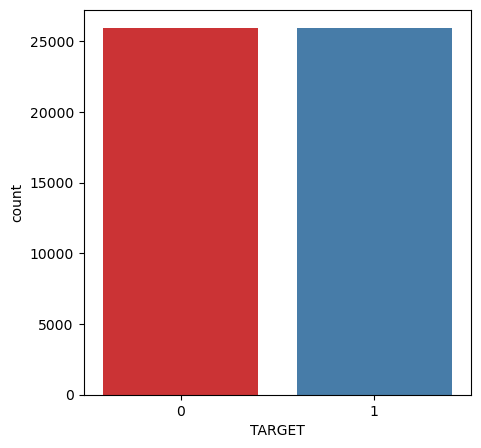

In [25]:
#checking for class imbalance
plt.figure(figsize=(5,5))
sns.countplot(x='TARGET', data = balanced_train_data, palette = "Set1" )

In [26]:
balanced_train_data.shape

(51870, 59)

In [27]:
#removing feature ID from dataset
# balanced_train_data.drop('ID',axis = 1, inplace = True)
balanced_train_data.head()

,Limit_balance,Age,Pay_1,Pay_2,Pay_3,Pay_4,Pay_5,Pay_6,Bill_amt1,Bill_amt2,Bill_amt3,Bill_amt4,Bill_amt5,Bill_amt6,Pay_amt1,Pay_amt2,Pay_amt3,Pay_amt4,Pay_amt5,Pay_amt6,Bureau_score,Tenure_years,Credit_utilisation_ratio,Average_payment_delay,Total_payments,Total_bill_amount,Payment_consistency,Sex_1,Sex_2,Education_0,Education_1,Education_2,Education_3,Education_4,Education_5,Education_6,Marriage_0,Marriage_1,Marriage_2,Marriage_3,City_Chicago,City_Houston,City_Los Angeles,City_New York,City_Phoenix,State_AZ,State_CA,State_IL,State_NY,State_TX,Credit_tier_Basic,Credit_tier_Gold,Credit_tier_Platinum,Credit_tier_Silver,Age_group_Middle-aged,Age_group_Senior,Age_group_Young,TARGET
0,120000.0,26.0,0.0,4.0,2.0,2.0,2.0,4.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,688.0,6.0,0.14,0.50,5000.0,17077.0,753.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,90000.0,34.0,2.0,2.0,2.0,2.0,2.0,2.0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,482.0,5.0,1.13,0.00,11018.0,101653.0,1570.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
2,50000.0,57.0,0.0,2.0,0.0,2.0,2.0,2.0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,560.0,7.0,2.19,-0.33,59049.0,109339.0,13786.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
3,50000.0,37.0,2.0,2.0,2.0,2.0,2.0,2.0,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,376.0,3.0,4.76,0.00,7772.0,238114.0,714.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
4,500000.0,29.0,2.0,2.0,2.0,2.0,2.0,2.0,367965.0,412023.0,445007.0,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,497.0,7.0,5.45,0.00,180759.0,2724595.0,16803.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0


In [28]:
# dependent and independent variabales
X = balanced_train_data[(list(i for i in list(balanced_train_data.describe(include='all').columns) if i != 'TARGET'))]
y = balanced_train_data['TARGET']

In [29]:
# scale
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [30]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)

In [31]:
#getting all score for logistic regression

def calculate_metrics(y_true_train, y_pred_train, y_true_test, y_pred_test):
    results = {}
    metrics = {
        'Accuracy_Train': accuracy_score,
        'Accuracy_Test': accuracy_score,
        'Precision_Test': precision_score,
        'Recall_Test': recall_score,
        'F1_Score_Test': f1_score,
        'ROC_AUC_Score_Test': roc_auc_score
    }
    
    for name, metric in metrics.items():
        if 'Train' in name:
            score = round(metric(y_pred_train, y_true_train), 3)
        else:
            score = round(metric(y_pred_test, y_true_test), 3)
        print(f"{name}: {score}")
        results[name] = score
        
    return results




In [32]:
# Model 1. Logistic regression
logistic_regression = LogisticRegression(fit_intercept=True, max_iter=10000)
logistic_regression.fit(X_train, y_train)

### Prediction
y_pred_logistic_regression = logistic_regression.predict(X_test)
y_train_pred_logistic_regression=logistic_regression.predict(X_train)

logistic_metrics = calculate_metrics(y_train, y_train_pred_logistic_regression, y_test, y_pred_logistic_regression)
logistic_accuracy_train = logistic_metrics['Accuracy_Train']
logistic_accuracy_test = logistic_metrics['Accuracy_Test']
logistic_precision_test = logistic_metrics['Precision_Test']
logistic_recall_test = logistic_metrics['Recall_Test']
logistic_f1_score_test = logistic_metrics['F1_Score_Test']
logistic_roc_auc_score_test = logistic_metrics['ROC_AUC_Score_Test']

Accuracy_Train: 0.695
Accuracy_Test: 0.693
Precision_Test: 0.69
Recall_Test: 0.694
F1_Score_Test: 0.692
ROC_AUC_Score_Test: 0.693


In [33]:
# Model 2. Decision Tree classifier
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train, y_train)

### Prediction
y_pred_decision_tree_classifier = decision_tree_classifier.predict(X_test)
y_train_pred_decision_tree_classifier=decision_tree_classifier.predict(X_train)

dct_metrics = calculate_metrics(y_train, y_train_pred_decision_tree_classifier, y_test, y_pred_decision_tree_classifier)
dct_accuracy_train = dct_metrics['Accuracy_Train']
dct_accuracy_test = dct_metrics['Accuracy_Test']
dct_precision_test = dct_metrics['Precision_Test']
dct_recall_test = dct_metrics['Recall_Test']
dct_f1_score_test = dct_metrics['F1_Score_Test']
dct_roc_auc_score_test = dct_metrics['ROC_AUC_Score_Test']

Accuracy_Train: 1.0
Accuracy_Test: 0.823
Precision_Test: 0.836
Recall_Test: 0.815
F1_Score_Test: 0.825
ROC_AUC_Score_Test: 0.823


In [34]:
# Model 3. RandomForestClassifier
random_forest_classifier=RandomForestClassifier(n_estimators=50)
random_forest_classifier.fit(X_train, y_train)

y_pred_random_forest_classifier=random_forest_classifier.predict(X_test)
y_train_pred_random_forest_classifier=random_forest_classifier.predict(X_train)

rfc_metrics = calculate_metrics(y_train, y_train_pred_random_forest_classifier, y_test, y_pred_random_forest_classifier)
rfc_accuracy_train = rfc_metrics['Accuracy_Train']
rfc_accuracy_test = rfc_metrics['Accuracy_Test']
rfc_precision_test = rfc_metrics['Precision_Test']
rfc_recall_test = rfc_metrics['Recall_Test']
rfc_f1_score_test = rfc_metrics['F1_Score_Test']
rfc_roc_auc_score_test = rfc_metrics['ROC_AUC_Score_Test']

Accuracy_Train: 1.0
Accuracy_Test: 0.894
Precision_Test: 0.85
Recall_Test: 0.931
F1_Score_Test: 0.889
ROC_AUC_Score_Test: 0.897


In [35]:
# Model 3. GradientBoostingClassifier
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)
gradient_boosting_classifier.fit(X_train, y_train)

y_pred_gradient_boosting_classifier=gradient_boosting_classifier.predict(X_test)
y_train_pred_gradient_boosting_classifier=gradient_boosting_classifier.predict(X_train)

gbc_metrics = calculate_metrics(y_train, y_train_pred_gradient_boosting_classifier, y_test, y_pred_gradient_boosting_classifier)
gbc_accuracy_train = gbc_metrics['Accuracy_Train']
gbc_accuracy_test = gbc_metrics['Accuracy_Test']
gbc_precision_test = gbc_metrics['Precision_Test']
gbc_recall_test = gbc_metrics['Recall_Test']
gbc_f1_score_test = gbc_metrics['F1_Score_Test']
gbc_roc_auc_score_test = gbc_metrics['ROC_AUC_Score_Test']

Accuracy_Train: 0.882
Accuracy_Test: 0.883
Precision_Test: 0.821
Recall_Test: 0.937
F1_Score_Test: 0.875
ROC_AUC_Score_Test: 0.889


In [36]:
# Model 4. Support vector machine
support_vector_machine=SVC(probability=True)
support_vector_machine.fit(X_train,y_train)

y_pred_support_vector_machine=support_vector_machine.predict(X_test)
y_train_pred_support_vector_machine=support_vector_machine.predict(X_train)

svm_metrics = calculate_metrics(y_train, y_train_pred_support_vector_machine, y_test, y_pred_support_vector_machine)
svm_accuracy_train = svm_metrics['Accuracy_Train']
svm_accuracy_test = svm_metrics['Accuracy_Test']
svm_precision_test = svm_metrics['Precision_Test']
svm_recall_test = svm_metrics['Recall_Test']
svm_f1_score_test = svm_metrics['F1_Score_Test']
svm_roc_auc_score_test = svm_metrics['ROC_AUC_Score_Test']

Accuracy_Train: 0.862
Accuracy_Test: 0.85
Precision_Test: 0.757
Recall_Test: 0.93
F1_Score_Test: 0.835
ROC_AUC_Score_Test: 0.863


In [37]:
# Model 4. XGBoost
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

y_pred_xgb=xgb.predict(X_test)
y_train_pred_xgb=xgb.predict(X_train)

xgb_metrics = calculate_metrics(y_train, y_train_pred_xgb, y_test, y_pred_xgb)
xgb_accuracy_train = xgb_metrics['Accuracy_Train']
xgb_accuracy_test = xgb_metrics['Accuracy_Test']
xgb_precision_test = xgb_metrics['Precision_Test']
xgb_recall_test = xgb_metrics['Recall_Test']
xgb_f1_score_test = xgb_metrics['F1_Score_Test']
xgb_roc_auc_score_test = xgb_metrics['ROC_AUC_Score_Test']


Accuracy_Train: 0.934
Accuracy_Test: 0.885
Precision_Test: 0.828
Recall_Test: 0.935
F1_Score_Test: 0.878
ROC_AUC_Score_Test: 0.89


In [39]:
all_classifiers = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVM', 'XG Boosting']
all_train_accuracy = [logistic_accuracy_train, dct_accuracy_train, rfc_accuracy_train, svm_accuracy_train, gbc_accuracy_train, xgb_accuracy_train]
all_test_accuracy = [logistic_accuracy_test, dct_accuracy_test, rfc_accuracy_test, svm_accuracy_test, gbc_accuracy_test, xgb_accuracy_test]
all_precision_score = [logistic_precision_test, dct_precision_test, rfc_precision_test, svm_precision_test, gbc_precision_test, xgb_precision_test]
all_recall_score = [logistic_recall_test, dct_recall_test, rfc_recall_test, svm_recall_test, gbc_recall_test, xgb_recall_test]
all_f1_score = [logistic_f1_score_test, dct_f1_score_test, rfc_f1_score_test, svm_f1_score_test, gbc_f1_score_test, xgb_f1_score_test]
all_auc_score = [logistic_roc_auc_score_test, dct_roc_auc_score_test, rfc_roc_auc_score_test, svm_roc_auc_score_test, gbc_roc_auc_score_test, xgb_roc_auc_score_test]

compare_df = pd.DataFrame({'Classifier':all_classifiers, 'Train Accuracy': all_train_accuracy, 'Test Accuracy': all_test_accuracy, 'Precision': all_precision_score, 'Recall': all_recall_score, 'F1 Score': all_f1_score , 'AUC': all_auc_score})
compare_df

,Classifier,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.695,0.693,0.690,0.694,0.692,0.693
1,Decision Tree,1.000,0.823,0.836,0.815,0.825,0.823
2,Random Forest,1.000,0.894,0.850,0.931,0.889,0.897
3,Gradient Boosting,0.862,0.850,0.757,0.930,0.835,0.863
4,SVM,0.882,0.883,0.821,0.937,0.875,0.889
5,XG Boosting,0.934,0.885,0.828,0.935,0.878,0.890


In [40]:
compare_df.sort_values(by=['Test Accuracy'], ascending=False)


,Classifier,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,AUC
2,Random Forest,1.000,0.894,0.850,0.931,0.889,0.897
5,XG Boosting,0.934,0.885,0.828,0.935,0.878,0.890
4,SVM,0.882,0.883,0.821,0.937,0.875,0.889
3,Gradient Boosting,0.862,0.850,0.757,0.930,0.835,0.863
1,Decision Tree,1.000,0.823,0.836,0.815,0.825,0.823
0,Logistic Regression,0.695,0.693,0.690,0.694,0.692,0.693
